In [1]:
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter

from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_validate
import lightgbm as lgbm

from settings import file_names

# Datasets

In [2]:
df_reviews = pd.read_csv(file_names['toronto_reviews_without_text'])
df_users = pd.read_csv(file_names['toronto_users'])
df_biz = pd.read_csv(file_names['toronto_businesses'])

In [3]:
df_tips = pd.read_json(file_names['tip'], encoding='utf-8', lines=True)
df_tips = df_tips.loc[df_tips['user_id'].isin(df_users.user_id.unique()) & df_tips['business_id'].isin(df_biz.business_id.unique())]
print('Number of Tips: ', df_tips.shape[0])
df_tips.head(3)

Number of Tips:  33192


,user_id,business_id,text,date,compliment_count
7,CaFbX7topxdLpBJ_SNDfGQ,r49iBfbnfoK7yt4rdsL_7g,Hands down best AYCE in town! Love it!,2016-01-05 06:39:33,0
10,8zXgNCkusOHMwh5Tj_8yCQ,qrSsS0pk7SL67MP5nN8tlg,More parking in the back of the restaurant,2013-12-22 05:10:12,0
13,oIHhfloe5VQamDFDB2dr1Q,wZhB4U003eg2GQ-F7D2D4A,When you receive the bag of seafood tie it up ...,2016-08-12 22:18:07,0


In [4]:
print('Number of reviews: ',df_reviews.shape[0])
print('Ratings describe: ', df_reviews['rating'].describe())
df_reviews.head(3)



Number of reviews:  228816
Ratings describe:  count    228816.000000
mean          3.643093
std           1.139687
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


,user_id,business_id,rating,date
0,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1.0,2012-07-16 00:37:14
1,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23
2,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4.0,2015-04-01 13:31:35


In [5]:
print('Number of users: ',df_users.shape[0])
df_users.head(3)

Number of users:  18804


,user_id,friends
0,gvXtMj3XuPr0xHjgmlmtng,"CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA..."
1,pU6GoRTcl1rIOi6zMynjog,"SwK2Oo8sjOH0yXYVoyjJwQ, 1LpChUg-0EqRKRKzL4ogYA..."
2,AsYMm_O4H-mwmWbmeACDHw,"w-bVY-dhpvnNs8W3BTTgAA, o_OEO0ES7oywPqENQR0f3A..."


In [6]:
print('Number of businesses: ',df_biz.shape[0])
df_biz.head(3)

Number of businesses:  7965


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas..."
1,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve..."
2,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,"{'Alcohol': ""u'full_bar'"", 'Caters': 'False', ...","Restaurants, Breakfast & Brunch, Bars, Modern ..."


### Small focus on coordinates --> We can use KMeans to keep track of the location

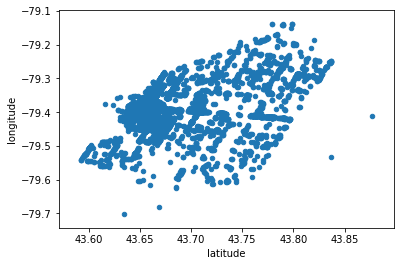

In [7]:
coordinates = df_biz[['latitude', 'longitude']]
coordinates.plot.scatter('latitude','longitude')

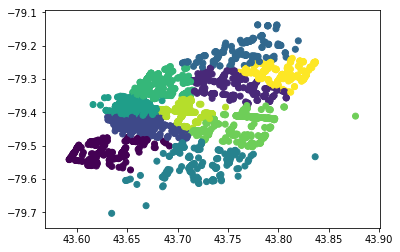

In [8]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=10)
clf.fit(coordinates)
coordinates_clusters = clf.labels_
plt.scatter(x = coordinates['latitude'], y = coordinates['longitude'], c=coordinates_clusters)

# Collaborative Filtering - Rating Prediction

In [9]:
from surprise import SVD, SVDpp, CoClustering, SlopeOne, KNNBasic, KNNWithZScore

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate as surprise_cv, GridSearchCV as surprise_gris_search_cv, train_test_split as surprise_test_train_split

df_surprise = df_reviews[['business_id', 'user_id', 'rating']]
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_surprise, reader)
algo = SVD()

surprise_cv(algo, data, measures=['RMSE', 'MAE', 'fcp'], cv=5, verbose=3, n_jobs=3)

Evaluating RMSE, MAE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0393  1.0367  1.0339  1.0353  1.0344  1.0359  0.0019  
MAE (testset)     0.8184  0.8181  0.8164  0.8156  0.8146  0.8166  0.0014  
FCP (testset)     0.5795  0.5816  0.5822  0.5834  0.5802  0.5814  0.0014  
Fit time          24.12   28.48   28.32   22.03   17.48   24.09   4.12    
Test time         1.43    1.10    0.74    0.67    0.75    0.94    0.29    


{'test_rmse': array([1.03927898, 1.0366635 , 1.03392706, 1.03533883, 1.03435578]),
 'test_mae': array([0.81839657, 0.81809079, 0.81636212, 0.8156458 , 0.81462724]),
 'test_fcp': array([0.57946517, 0.58160647, 0.58224493, 0.58335696, 0.58020409]),
 'fit_time': (24.12421703338623,
  28.48486089706421,
  28.31532883644104,
  22.03124976158142,
  17.48184299468994),
 'test_time': (1.4333078861236572,
  1.0977861881256104,
  0.7436609268188477,
  0.6670510768890381,
  0.7513899803161621)}

In [10]:
trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

FCP:  0.5812
MAE:  0.8174
0.5811879688310762 0.8173859492504839


In [11]:
predictions[:2]

[Prediction(uid='BS0GcQ1kUag8YJ2qcBH2lQ', iid='TbhyP24zYZqZ2VJZgu1wrg', r_ui=3.0, est=3.46956854651741, details={'was_impossible': False}),
 Prediction(uid='ruR-mrEaNbFJGnM-WCbcgg', iid='y1f4CLq0JLIaQTEnMUIrJQ', r_ui=4.0, est=3.313250708691617, details={'was_impossible': False})]

# Baseline Binary Prediction - Collaborative Filtering

In [12]:
from networkx.algorithms import bipartite

g = nx.Graph()
g.add_nodes_from(df_users.user_id.unique(), bipartite=0)
g.add_nodes_from(df_biz.business_id.unique(), bipartite=1)

g.add_edges_from([(user, business) for user, business
                           in zip(df_reviews.user_id, df_reviews.business_id)])

In [13]:
binary_data = bipartite.biadjacency_matrix(g, df_users.user_id.unique()).todense()
df_binary = pd.DataFrame(binary_data)
df_binary['user_id'] = df_binary.index.values
df_binary.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7954,7955,7956,7957,7958,7959,7960,7961,7962,user_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [14]:
df_binary = pd.melt(df_binary, id_vars='user_id')
df_binary.rename({'variable':'business_id', 'value':'has_reviewed'}, axis='columns', inplace=True)

In [15]:
df_binary

,user_id,business_id,has_reviewed
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
149736247,18799,7962,0
149736248,18800,7962,0
149736249,18801,7962,0
149736250,18802,7962,0


In [16]:
def negative_sampling(df, ratio_zeros_on_ones):
    df_zeros = df_binary.loc[df_binary['has_reviewed'] == 0]
    df_ones = df_binary.loc[df_binary['has_reviewed'] != 0]
    df_zeros = df_zeros.sample(n=int(df_ones.shape[0]*ratio_zeros_on_ones))
    return pd.concat([df_zeros, df_ones]).sample(frac=1).reset_index(drop=True)

In [17]:
reader = Reader(rating_scale=(0, 1))

In [18]:
pd.read_csv('results_grid_search_1.csv')

,Unnamed: 0,algo,ratio,fcp,mae
0,0,<surprise.prediction_algorithms.matrix_factori...,1,0.685010,0.299105
1,1,<surprise.prediction_algorithms.matrix_factori...,1,0.693832,0.287712
2,2,<surprise.prediction_algorithms.co_clustering....,1,0.662593,0.254488
3,3,<surprise.prediction_algorithms.slope_one.Slop...,1,0.671566,0.320343
4,4,<surprise.prediction_algorithms.knns.KNNBasic ...,1,0.696282,0.366031
5,5,<surprise.prediction_algorithms.knns.KNNWithZS...,1,0.687305,0.295729
6,6,<surprise.prediction_algorithms.matrix_factori...,3,0.736513,0.236169
7,7,<surprise.prediction_algorithms.matrix_factori...,3,0.753481,0.229350
8,8,<surprise.prediction_algorithms.co_clustering....,3,0.738933,0.208497
9,9,<surprise.prediction_algorithms.slope_one.Slop...,3,0.742451,0.226969


In [ ]:
data = negative_sampling(df_binary, 10)
data = Dataset.load_from_df(data, reader)
trainset, testset = surprise_test_train_split(data, test_size=0.25)
algo = algo_()
algo.fit(trainset)
predictions = algo.test(testset)

# Binary Prediction - Using Graph Analysis
- Community detection
    - User --[Friends]-->User
    - User --[Reviewed]-->Restaurant
    - User --[Friends]-->User & User --[Reviewed]-->Restaurant
- Build feature 

In [1]:
from graph import *
g_friends = make_friends_graph()
g_bipartite = make_user_business_bipartite_graph(weighted=False, minimum_rating=4)
g_full = make_frienships_and_reviews_graph(weight_ratio=1, minimum_rating=0)